/var/folders/tw/j68gkt955z57h83crjdjjrg80000gr/T/ipykernel_37510/2163368960.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels, cmap=matplotlib.cm.get_cmap('RdYlBu_r'))


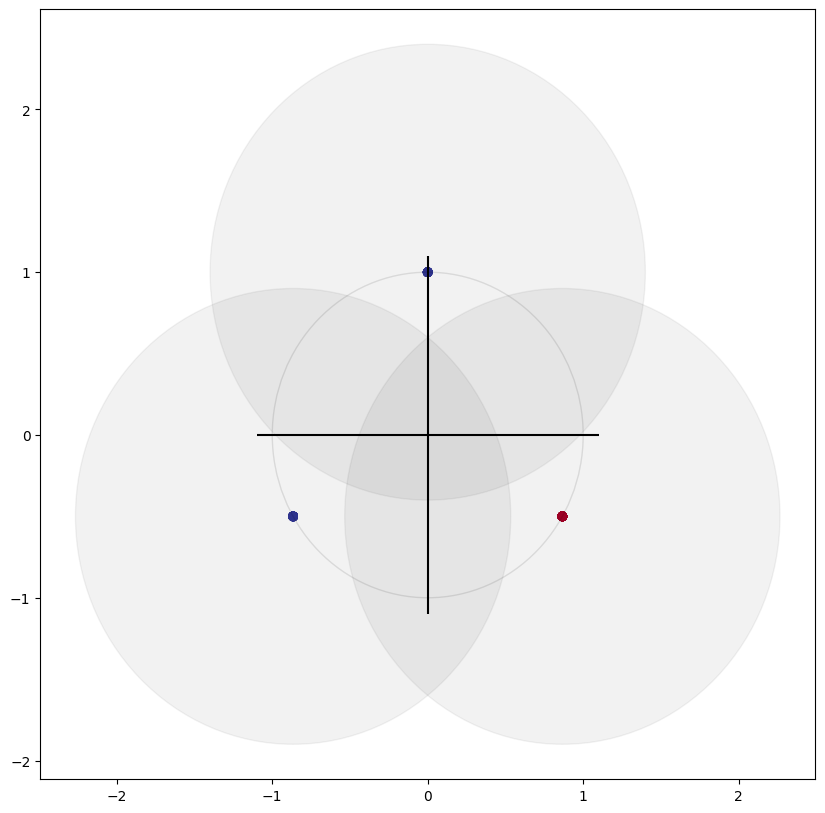

In [1]:
import os, sys, numpy, torch, matplotlib.pyplot, matplotlib.cm, ipycanvas, matplotlib.patches

sys.path += [os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('../..'))]  # Allow repository modules to be imported

from settings.sphere_2d_epsilon_net import sphere_2d_epsilon_net, get_dataloader
from utils.optimization import initialize

experiment = {
    'dataset': 'sphere_2d_epsilon_net',
    'epsilon': 1.4,
    'net_epsilon': 0.01,
    'seed': 2,
    'input_dimension': 2, 
    'sample_size': 100,  
    'batch_size': 100, 
    'within_cluster_variance': 0,
    'epochs': 10000,
    'learning_rate': .1,
    'bias': False,
    'initial_hidden_units': 200,
    'initialization_scale': 1e-25,
    'name_parameters': ['epoch'],
    'balance_classes': True,
    'balanced_initialization': True
}
rotation_matrix = numpy.identity(experiment['input_dimension'])
device, generator = initialize(experiment['seed'])
train_data = get_dataloader(**experiment, rotation_matrix=rotation_matrix, generator=generator)
test_data = get_dataloader(**experiment, rotation_matrix=rotation_matrix, generator=generator)

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
inputs = []; labels = []
for batch_inputs, batch_labels in train_data: inputs.append(batch_inputs); labels.append(batch_labels)
inputs, labels = torch.concatenate(inputs), torch.concatenate(labels)
inputs_ = numpy.matmul(inputs.detach().cpu().numpy(), rotation_matrix.transpose())
ax.hlines(0, -inputs_.max() * 1.1, inputs_.max() * 1.1, color='k')
ax.vlines(0, -inputs_.max() * 1.1, inputs_.max() * 1.1, color='k')
ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels, cmap=matplotlib.cm.get_cmap('RdYlBu_r'))
nodes = sphere_2d_epsilon_net(**experiment)
ax.add_patch(matplotlib.patches.Circle([0, 0], 1, color='k', alpha=.1, fill=False))
for node in nodes:
    ax.add_patch(matplotlib.patches.Circle(node, experiment['epsilon'], color='k', alpha=.05))

In [2]:
matplotlib.pyplot.ioff()
figure, ((input_domain_ax, loss_ax), (parameters_norms_ax, gradients_norms_ax)) = matplotlib.pyplot.subplots(2, 2, figsize=(16, 16))

canvas = ipycanvas.Canvas()
canvas.width, canvas.height = 1200, 1200
canvas.font = '30px arial'
canvas.fill_text('Results will appear as processed', canvas.width / 4, canvas.height / 3)
canvas

Canvas(height=1200, width=1200)

In [3]:
from functools import partial
from utils.plots import (plot_train_loss, plot_samples_and_neurons, plot_weights_gradient_norms, 
                         plot_weights_norms, draw_figure_into_canvas, save_figure)
from model import FullyConnectedNeuralNetwork
from experiment import execute_experiment

plot_samples_and_neurons = partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
plot_train_loss = partial(plot_train_loss, ax=loss_ax)
plot_weights_norms = partial(plot_weights_norms, ax=parameters_norms_ax)
plot_weights_gradient_norms = partial(plot_weights_gradient_norms, ax=gradients_norms_ax)
draw_figure_into_canvas = partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure = partial(save_figure, figure=figure, parameters=experiment, **experiment)

def model_summary(model, model_metrics, epoch, *args, **kwargs):
    for layer_index, layer in enumerate(model.layers):
        layer_metrics = {'epoch': epoch, 'layer': layer_index, 'hidden_units': layer.weight.shape[0],
                         'neurons_weights_norm': layer.weight.norm(dim=1).detach().cpu().tolist()}
        if experiment['bias']: layer_metrics.update({'biases': layer.bias.detach().cpu().tolist()})
        model_metrics.append(layer_metrics)
        
    model_metrics.append({'epoch': epoch, 'layer': len(model.layers), 'hidden_units': model.output_layer.weight.shape[1],
                          'neurons_weights_norm': model.output_layer.weight.abs().squeeze(dim=0).detach().cpu().tolist()})

execute_experiment(
    **experiment,
    train_data=train_data, 
    test_data=test_data, 
    model_class=FullyConnectedNeuralNetwork,
    saving_epochs_interval=experiment['epochs'],
    callbacks_epochs=list(range(0, 10000, 100)),
    callbacks=[model_summary, plot_samples_and_neurons, plot_train_loss, plot_weights_norms, 
               plot_weights_gradient_norms, draw_figure_into_canvas, save_figure],
    overwrite=True
)

/Users/LePalma/Documents/git/nns_growth/notebooks/utils/models.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.output_layer.weight.copy_(self.output_layer.weight.sign() * torch.tensor(self.layers[-1].weight.norm(dim=1)))


KeyboardInterrupt: 